In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 29 20:32:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   32C    P8    22W / 250W |   1395MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 400

# Name is the output file name


##  200719  mds
folder = '29July2020_Trks_to_KDE_C_lossB_another_400_epochs_b64_3m4_nOut_50x50'
name = '29July2020_Trks_to_KDE_C_lossB_another_400_epochs_b64_3m4_nOut_50x50'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_kde import collect_t2kde_data

# From model/loss.py
##from loss import Loss
from model.kde_loss_B import Loss


from model.models_kde import TracksToKDE_C as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch

train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

Loading data...
len(X) =  20000
len(Xlist) =  1
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 4.536 s
outer loop X.shape =  (20000, 6, 600)
Constructing 18000 event dataset took 2.425 s
x_t.shape =  torch.Size([18000, 6, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  6
x_t.shape =  torch.Size([18000, 6, 600])
Loading data...
len(X) =  20000
len(Xlist) =  1
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 4.658 s
outer loop X.shape =  (20000, 6, 600)
Constructing 2000 event dataset took 0.04014 s
x_t.shape =  torch.Size([2000, 6, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  6
x_t.shape =  torch.Size([2000, 6, 600])


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
model = Model(nOut1,nOut2)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=6, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=4000, bias=True)


In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

print(" \n","  for pretrained_dict")
index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/29July2020_Trks_to_KDE_C_lossB_another_400_epochs_b64_3m4_nOut_50x50
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
 
   for pretrained_dict
pretrained_dict iterated


<All keys matched successfully>

In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
model = model.to(device)

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


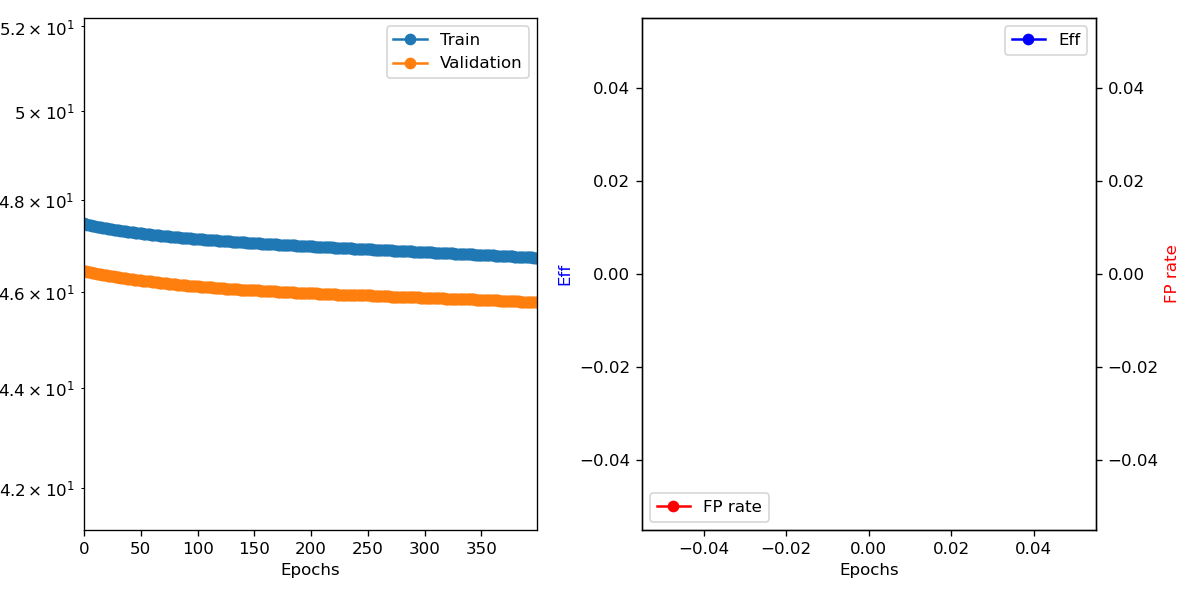

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 282, val = 32


Number of batches: train = 282, val = 32


Epoch 0: train=47.4788, val=46.444, took 7.5553 s


Epoch 1: train=47.458, val=46.4375, took 7.1957 s


Epoch 2: train=47.4521, val=46.4313, took 7.1955 s


Epoch 3: train=47.4463, val=46.4258, took 7.207 s


Epoch 4: train=47.4407, val=46.4195, took 7.2096 s


Epoch 5: train=47.435, val=46.4148, took 7.2138 s


Epoch 6: train=47.4296, val=46.4087, took 7.2258 s


Epoch 7: train=47.4244, val=46.4044, took 7.2166 s


Epoch 8: train=47.4195, val=46.3996, took 7.3065 s


Epoch 9: train=47.4145, val=46.3934, took 7.378 s


Epoch 10: train=47.4095, val=46.3901, took 7.3298 s


Epoch 11: train=47.4045, val=46.3859, took 7.3018 s


Epoch 12: train=47.3998, val=46.3809, took 7.315 s


Epoch 13: train=47.3952, val=46.3769, took 7.3717 s


Epoch 14: train=47.3906, val=46.372, took 7.4166 s


Epoch 15: train=47.386, val=46.3675, took 7.4266 s


Epoch 16: train=47.3815, val=46.3646, took 7.4239 s


Epoch 17: train=47.3772, val=46.3605, took 7.4284 s


Epoch 18: train=47.373, val=46.3558, took 7.4272 s


Epoch 19: train=47.3687, val=46.352, took 7.4283 s


Epoch 20: train=47.3642, val=46.3488, took 7.4287 s


Epoch 21: train=47.3597, val=46.3431, took 7.4198 s


Epoch 22: train=47.3552, val=46.3386, took 7.4444 s


Epoch 23: train=47.3511, val=46.3344, took 7.3749 s


Epoch 24: train=47.3471, val=46.3294, took 7.3252 s


Epoch 25: train=47.343, val=46.3262, took 7.321 s


Epoch 26: train=47.3391, val=46.3227, took 7.3238 s


Epoch 27: train=47.3352, val=46.3189, took 7.3327 s


Epoch 28: train=47.3314, val=46.3165, took 7.3325 s


Epoch 29: train=47.3274, val=46.3118, took 7.3894 s


Epoch 30: train=47.3238, val=46.3079, took 7.4521 s


Epoch 31: train=47.32, val=46.3052, took 7.4103 s


Epoch 32: train=47.3164, val=46.2999, took 7.33 s


Epoch 33: train=47.3127, val=46.2964, took 7.3361 s


Epoch 34: train=47.3092, val=46.2937, took 7.3533 s


Epoch 35: train=47.3055, val=46.2889, took 7.3519 s


Epoch 36: train=47.3021, val=46.2857, took 7.3428 s


Epoch 37: train=47.2983, val=46.2831, took 7.3867 s


Epoch 38: train=47.2948, val=46.2793, took 7.4067 s


Epoch 39: train=47.2915, val=46.2764, took 7.4436 s


Epoch 40: train=47.2881, val=46.2725, took 7.3988 s


Epoch 41: train=47.285, val=46.2699, took 7.4496 s


Epoch 42: train=47.2817, val=46.2665, took 7.4328 s


Epoch 43: train=47.2783, val=46.2625, took 7.494 s


Epoch 44: train=47.2752, val=46.2571, took 7.3879 s


Epoch 45: train=47.2719, val=46.2544, took 7.3984 s


Epoch 46: train=47.2688, val=46.2491, took 7.4294 s


Epoch 47: train=47.2657, val=46.2477, took 7.4004 s


Epoch 48: train=47.2626, val=46.2451, took 7.4347 s


Epoch 49: train=47.2596, val=46.2423, took 7.3387 s


Epoch 50: train=47.2564, val=46.2386, took 7.4036 s


Epoch 51: train=47.2533, val=46.2357, took 7.4307 s


Epoch 52: train=47.2504, val=46.2327, took 7.4309 s


Epoch 53: train=47.2474, val=46.23, took 7.429 s


Epoch 54: train=47.2444, val=46.2268, took 7.3924 s


Epoch 55: train=47.2416, val=46.2226, took 7.3268 s


Epoch 56: train=47.2388, val=46.2221, took 7.3252 s


Epoch 57: train=47.2364, val=46.2188, took 7.3192 s


Epoch 58: train=47.2332, val=46.2179, took 7.3331 s


Epoch 59: train=47.2306, val=46.2161, took 7.3296 s


Epoch 60: train=47.2278, val=46.2096, took 7.3404 s


Epoch 61: train=47.2249, val=46.2081, took 7.5055 s


Epoch 62: train=47.2222, val=46.2038, took 7.4183 s


Epoch 63: train=47.2193, val=46.201, took 7.4446 s


Epoch 64: train=47.2165, val=46.1974, took 7.4415 s


Epoch 65: train=47.2137, val=46.1956, took 7.3711 s


Epoch 66: train=47.2111, val=46.1937, took 7.4426 s


Epoch 67: train=47.2085, val=46.1908, took 7.446 s


Epoch 68: train=47.2059, val=46.1877, took 7.435 s


Epoch 69: train=47.2034, val=46.1851, took 7.4435 s


Epoch 70: train=47.201, val=46.1839, took 7.4426 s


Epoch 71: train=47.1985, val=46.1809, took 7.4078 s


Epoch 72: train=47.1961, val=46.1778, took 7.357 s


Epoch 73: train=47.1937, val=46.1754, took 7.3867 s


Epoch 74: train=47.1912, val=46.1723, took 7.4211 s


Epoch 75: train=47.1887, val=46.1686, took 7.3994 s


Epoch 76: train=47.1862, val=46.1667, took 7.4537 s


Epoch 77: train=47.1837, val=46.1633, took 7.3858 s


Epoch 78: train=47.1814, val=46.1618, took 7.4175 s


Epoch 79: train=47.1792, val=46.1572, took 7.4481 s


Epoch 80: train=47.1769, val=46.155, took 7.3358 s


Epoch 81: train=47.1745, val=46.1538, took 7.3505 s


Epoch 82: train=47.1721, val=46.151, took 7.4297 s


Epoch 83: train=47.1698, val=46.1494, took 7.4389 s


Epoch 84: train=47.1673, val=46.1473, took 7.314 s


Epoch 85: train=47.1651, val=46.1458, took 7.4344 s


Epoch 86: train=47.1626, val=46.1417, took 7.4486 s


Epoch 87: train=47.1605, val=46.1399, took 7.425 s


Epoch 88: train=47.1583, val=46.1365, took 7.3837 s


Epoch 89: train=47.1561, val=46.1338, took 7.4258 s


Epoch 90: train=47.154, val=46.1307, took 7.4277 s


Epoch 91: train=47.1517, val=46.128, took 7.4122 s


Epoch 92: train=47.1496, val=46.1264, took 7.4107 s


Epoch 93: train=47.1477, val=46.1245, took 7.4208 s


Epoch 94: train=47.1456, val=46.122, took 7.3685 s


Epoch 95: train=47.1435, val=46.1206, took 7.4049 s


Epoch 96: train=47.1416, val=46.1188, took 7.4399 s


Epoch 97: train=47.1395, val=46.1168, took 7.4096 s


Epoch 98: train=47.1372, val=46.1147, took 7.4451 s


Epoch 99: train=47.1354, val=46.1116, took 7.4684 s


Epoch 100: train=47.1336, val=46.1105, took 7.3597 s


Epoch 101: train=47.1314, val=46.1088, took 7.3645 s


Epoch 102: train=47.1293, val=46.1061, took 7.4609 s


Epoch 103: train=47.1272, val=46.1037, took 7.4534 s


Epoch 104: train=47.1254, val=46.1039, took 7.3833 s


Epoch 105: train=47.1236, val=46.1023, took 7.4694 s


Epoch 106: train=47.1217, val=46.1005, took 7.437 s


Epoch 107: train=47.12, val=46.0986, took 7.4545 s


Epoch 108: train=47.1179, val=46.0975, took 7.4624 s


Epoch 109: train=47.1159, val=46.0948, took 7.4209 s


Epoch 110: train=47.1141, val=46.0928, took 7.4666 s


Epoch 111: train=47.1121, val=46.092, took 7.4269 s


Epoch 112: train=47.1103, val=46.0896, took 7.4344 s


Epoch 113: train=47.1085, val=46.0888, took 7.4356 s


Epoch 114: train=47.1067, val=46.0867, took 7.4373 s


Epoch 115: train=47.1047, val=46.0832, took 7.4663 s


Epoch 116: train=47.1026, val=46.0817, took 7.4644 s


Epoch 117: train=47.1009, val=46.081, took 7.4781 s


Epoch 118: train=47.0988, val=46.0779, took 7.4427 s


Epoch 119: train=47.0972, val=46.0761, took 7.4416 s


Epoch 120: train=47.0952, val=46.0736, took 7.4506 s


Epoch 121: train=47.0934, val=46.0715, took 7.4214 s


Epoch 122: train=47.0916, val=46.07, took 7.3774 s


Epoch 123: train=47.09, val=46.0682, took 7.4548 s


Epoch 124: train=47.0881, val=46.0653, took 7.4437 s


Epoch 125: train=47.0862, val=46.0645, took 7.4537 s


Epoch 126: train=47.0845, val=46.0618, took 7.4577 s


Epoch 127: train=47.0828, val=46.0606, took 7.4196 s


Epoch 128: train=47.081, val=46.0593, took 7.4681 s


Epoch 129: train=47.0794, val=46.0577, took 7.4412 s


Epoch 130: train=47.0777, val=46.0559, took 7.4421 s


Epoch 131: train=47.0759, val=46.0542, took 7.4169 s


Epoch 132: train=47.074, val=46.0526, took 7.4075 s


Epoch 133: train=47.0723, val=46.0506, took 7.4099 s


Epoch 134: train=47.0705, val=46.048, took 7.3874 s


Epoch 135: train=47.0687, val=46.0474, took 7.3952 s


Epoch 136: train=47.0671, val=46.0457, took 7.4369 s


Epoch 137: train=47.0653, val=46.0446, took 7.4206 s


Epoch 138: train=47.0635, val=46.0431, took 7.4089 s


Epoch 139: train=47.0617, val=46.0418, took 7.4279 s


Epoch 140: train=47.0599, val=46.0415, took 7.3403 s


Epoch 141: train=47.0582, val=46.0395, took 7.4306 s


Epoch 142: train=47.0566, val=46.039, took 7.3837 s


Epoch 143: train=47.0547, val=46.039, took 7.3635 s


Epoch 144: train=47.0529, val=46.0369, took 7.4129 s


Epoch 145: train=47.0513, val=46.0366, took 7.4523 s


Epoch 146: train=47.0497, val=46.0361, took 7.4339 s


Epoch 147: train=47.0483, val=46.034, took 7.4212 s


Epoch 148: train=47.0464, val=46.0327, took 7.4552 s


Epoch 149: train=47.0451, val=46.0305, took 7.4599 s


Epoch 150: train=47.0431, val=46.0297, took 7.4091 s


Epoch 151: train=47.0418, val=46.0269, took 7.4223 s


Epoch 152: train=47.04, val=46.0258, took 7.4196 s


Epoch 153: train=47.0385, val=46.0254, took 7.4325 s


Epoch 154: train=47.0371, val=46.0241, took 7.4067 s


Epoch 155: train=47.0355, val=46.0217, took 7.3705 s


Epoch 156: train=47.0341, val=46.0201, took 7.3926 s


Epoch 157: train=47.0324, val=46.0185, took 7.3911 s


Epoch 158: train=47.0312, val=46.0166, took 7.4421 s


Epoch 159: train=47.0295, val=46.0157, took 7.448 s


Epoch 160: train=47.0282, val=46.0139, took 7.4121 s


Epoch 161: train=47.0267, val=46.0125, took 7.4566 s


Epoch 162: train=47.0253, val=46.0125, took 7.4049 s


Epoch 163: train=47.0238, val=46.0123, took 7.4474 s


Epoch 164: train=47.0224, val=46.0091, took 7.4406 s


Epoch 165: train=47.021, val=46.0076, took 7.4213 s


Epoch 166: train=47.0198, val=46.0063, took 7.3341 s


Epoch 167: train=47.0183, val=46.0054, took 7.4102 s


Epoch 168: train=47.017, val=46.0044, took 7.4447 s


Epoch 169: train=47.0156, val=46.0032, took 7.4091 s


Epoch 170: train=47.0139, val=46.002, took 7.4321 s


Epoch 171: train=47.0126, val=46.0002, took 7.4554 s


Epoch 172: train=47.0112, val=45.9988, took 7.4546 s


Epoch 173: train=47.0097, val=45.9983, took 7.422 s


Epoch 174: train=47.0086, val=45.9953, took 7.3426 s


Epoch 175: train=47.0073, val=45.9952, took 7.3344 s


Epoch 176: train=47.0059, val=45.9941, took 7.4604 s


Epoch 177: train=47.0044, val=45.9928, took 7.4545 s


Epoch 178: train=47.0032, val=45.9908, took 7.4629 s


Epoch 179: train=47.0019, val=45.9899, took 7.4335 s


Epoch 180: train=47.0003, val=45.9894, took 7.4436 s


Epoch 181: train=46.9991, val=45.9885, took 7.4603 s


Epoch 182: train=46.9978, val=45.9879, took 7.4455 s


Epoch 183: train=46.9965, val=45.9847, took 7.4367 s


Epoch 184: train=46.9949, val=45.982, took 7.4691 s


Epoch 185: train=46.9937, val=45.9818, took 7.4227 s


Epoch 186: train=46.9923, val=45.9803, took 7.4404 s


Epoch 187: train=46.9908, val=45.9786, took 7.3841 s


Epoch 188: train=46.9895, val=45.9775, took 7.3391 s


Epoch 189: train=46.988, val=45.975, took 7.4645 s


Epoch 190: train=46.9868, val=45.9747, took 7.4367 s


Epoch 191: train=46.9854, val=45.9733, took 7.4221 s


Epoch 192: train=46.984, val=45.9721, took 7.4754 s


Epoch 193: train=46.9827, val=45.971, took 7.4184 s


Epoch 194: train=46.9812, val=45.9709, took 7.3546 s


Epoch 195: train=46.98, val=45.9703, took 7.4162 s


Epoch 196: train=46.9785, val=45.9695, took 7.3945 s


Epoch 197: train=46.9772, val=45.9677, took 7.4421 s


Epoch 198: train=46.9759, val=45.9674, took 7.4468 s


Epoch 199: train=46.9746, val=45.9664, took 7.4496 s


Epoch 200: train=46.9734, val=45.966, took 7.4064 s


Epoch 201: train=46.9722, val=45.9638, took 7.3924 s


Epoch 202: train=46.9708, val=45.9634, took 7.4132 s


Epoch 203: train=46.9695, val=45.9637, took 7.4152 s


Epoch 204: train=46.9683, val=45.9621, took 7.3664 s


Epoch 205: train=46.967, val=45.9599, took 7.363 s


Epoch 206: train=46.9657, val=45.9586, took 7.4612 s


Epoch 207: train=46.9644, val=45.9573, took 7.4032 s


Epoch 208: train=46.9631, val=45.9576, took 7.4443 s


Epoch 209: train=46.9619, val=45.9544, took 7.4468 s


Epoch 210: train=46.9606, val=45.9545, took 7.4193 s


Epoch 211: train=46.9595, val=45.9539, took 7.3659 s


Epoch 212: train=46.9582, val=45.9537, took 7.3772 s


Epoch 213: train=46.9569, val=45.9526, took 7.4295 s


Epoch 214: train=46.9557, val=45.9519, took 7.3804 s


Epoch 215: train=46.9544, val=45.9509, took 7.4458 s


Epoch 216: train=46.9531, val=45.9505, took 7.4369 s


Epoch 217: train=46.9518, val=45.9489, took 7.3176 s


Epoch 218: train=46.9502, val=45.9475, took 7.4191 s


Epoch 219: train=46.9492, val=45.9439, took 7.4258 s


Epoch 220: train=46.9477, val=45.941, took 7.4147 s


Epoch 221: train=46.9463, val=45.9401, took 7.4008 s


Epoch 222: train=46.9448, val=45.9391, took 7.416 s


Epoch 223: train=46.9436, val=45.9366, took 7.4615 s


Epoch 224: train=46.9424, val=45.9349, took 7.4223 s


Epoch 225: train=46.9412, val=45.9337, took 7.4268 s


Epoch 226: train=46.94, val=45.9352, took 7.4677 s


Epoch 227: train=46.9386, val=45.9333, took 7.4038 s


Epoch 228: train=46.9372, val=45.9322, took 7.4361 s


Epoch 229: train=46.9361, val=45.9341, took 7.4125 s


Epoch 230: train=46.9347, val=45.9322, took 7.4312 s


Epoch 231: train=46.9337, val=45.931, took 7.4156 s


Epoch 232: train=46.9325, val=45.9298, took 7.4164 s


Epoch 233: train=46.9312, val=45.9299, took 7.5522 s


Epoch 234: train=46.9299, val=45.9287, took 7.4641 s


Epoch 235: train=46.9288, val=45.9279, took 7.5282 s


Epoch 236: train=46.9274, val=45.9271, took 7.613 s


Epoch 237: train=46.9261, val=45.9249, took 8.2293 s


Epoch 238: train=46.925, val=45.9252, took 7.856 s


Epoch 239: train=46.9238, val=45.9235, took 8.4021 s


Epoch 240: train=46.9225, val=45.9227, took 8.1756 s


Epoch 241: train=46.9212, val=45.9237, took 7.8925 s


Epoch 242: train=46.9201, val=45.9216, took 8.0564 s


Epoch 243: train=46.9189, val=45.9231, took 8.6083 s


Epoch 244: train=46.9177, val=45.9228, took 8.2199 s


Epoch 245: train=46.9165, val=45.9238, took 8.265 s


Epoch 246: train=46.9154, val=45.9211, took 8.0952 s


Epoch 247: train=46.914, val=45.9222, took 8.1064 s


Epoch 248: train=46.913, val=45.9222, took 8.2145 s


Epoch 249: train=46.9117, val=45.9217, took 7.8727 s


Epoch 250: train=46.9104, val=45.9205, took 8.0416 s


Epoch 251: train=46.9091, val=45.9196, took 8.3058 s


Epoch 252: train=46.9081, val=45.9194, took 8.4133 s


Epoch 253: train=46.9068, val=45.9179, took 8.0774 s


Epoch 254: train=46.9054, val=45.9161, took 7.9187 s


Epoch 255: train=46.9042, val=45.9148, took 8.9438 s


Epoch 256: train=46.9028, val=45.9142, took 7.6294 s


Epoch 257: train=46.9015, val=45.9123, took 7.7895 s


Epoch 258: train=46.9003, val=45.9116, took 7.9164 s


Epoch 259: train=46.899, val=45.9096, took 8.9728 s


Epoch 260: train=46.8976, val=45.9087, took 9.5257 s


Epoch 261: train=46.8961, val=45.9076, took 9.3955 s


Epoch 262: train=46.8949, val=45.9063, took 9.7472 s


Epoch 263: train=46.8938, val=45.9056, took 7.9994 s


Epoch 264: train=46.8923, val=45.904, took 8.8231 s


Epoch 265: train=46.8912, val=45.902, took 7.8319 s


Epoch 266: train=46.8898, val=45.9016, took 7.7859 s


Epoch 267: train=46.8887, val=45.9016, took 9.366 s


Epoch 268: train=46.8874, val=45.8986, took 9.7319 s


Epoch 269: train=46.8861, val=45.8976, took 9.6423 s


Epoch 270: train=46.8848, val=45.896, took 9.7074 s


Epoch 271: train=46.8834, val=45.8946, took 7.8371 s


Epoch 272: train=46.8823, val=45.8943, took 9.4103 s


Epoch 273: train=46.8807, val=45.892, took 7.7253 s


Epoch 274: train=46.8794, val=45.893, took 7.7036 s


Epoch 275: train=46.878, val=45.8921, took 7.832 s


Epoch 276: train=46.8768, val=45.891, took 7.9035 s


Epoch 277: train=46.8756, val=45.8898, took 7.9469 s


Epoch 278: train=46.8746, val=45.8885, took 8.0186 s


Epoch 279: train=46.8733, val=45.8887, took 7.7646 s


Epoch 280: train=46.8722, val=45.8882, took 8.5771 s


Epoch 281: train=46.8708, val=45.8875, took 8.5563 s


Epoch 282: train=46.8697, val=45.8871, took 7.9065 s


Epoch 283: train=46.8685, val=45.8858, took 7.8452 s


Epoch 284: train=46.8672, val=45.8845, took 7.9737 s


Epoch 285: train=46.8661, val=45.8826, took 7.9164 s


Epoch 286: train=46.8649, val=45.8828, took 7.7515 s


Epoch 287: train=46.8636, val=45.8815, took 7.8064 s


Epoch 288: train=46.8624, val=45.8806, took 7.931 s


Epoch 289: train=46.8613, val=45.8793, took 8.0793 s


Epoch 290: train=46.8597, val=45.8793, took 8.5948 s


Epoch 291: train=46.8588, val=45.8772, took 7.7604 s


Epoch 292: train=46.8576, val=45.8771, took 7.8346 s


Epoch 293: train=46.8563, val=45.8761, took 7.8462 s


Epoch 294: train=46.8552, val=45.8761, took 8.8253 s


Epoch 295: train=46.854, val=45.8756, took 8.7015 s


Epoch 296: train=46.8529, val=45.8745, took 7.798 s


Epoch 297: train=46.8516, val=45.8732, took 8.1514 s


Epoch 298: train=46.8508, val=45.8738, took 7.7844 s


Epoch 299: train=46.8495, val=45.8733, took 7.8281 s


Epoch 300: train=46.8481, val=45.8713, took 8.2989 s


Epoch 301: train=46.8469, val=45.8701, took 8.0313 s


Epoch 302: train=46.8459, val=45.8697, took 8.0692 s


Epoch 303: train=46.845, val=45.8693, took 7.9868 s


Epoch 304: train=46.8439, val=45.8694, took 8.5556 s


Epoch 305: train=46.8427, val=45.8667, took 7.9191 s


Epoch 306: train=46.8417, val=45.865, took 8.2055 s


Epoch 307: train=46.8403, val=45.863, took 8.1533 s


Epoch 308: train=46.8392, val=45.8628, took 7.9555 s


Epoch 309: train=46.838, val=45.8621, took 8.058 s


Epoch 310: train=46.8369, val=45.8619, took 8.0157 s


Epoch 311: train=46.8357, val=45.8608, took 8.0179 s


Epoch 312: train=46.8347, val=45.8582, took 7.7196 s


Epoch 313: train=46.8331, val=45.8586, took 7.8145 s


Epoch 314: train=46.8323, val=45.8573, took 7.7733 s


Epoch 315: train=46.8309, val=45.8567, took 7.7962 s


Epoch 316: train=46.83, val=45.8545, took 7.8514 s


Epoch 317: train=46.8286, val=45.8561, took 7.6732 s


Epoch 318: train=46.8276, val=45.8527, took 7.72 s


Epoch 319: train=46.8263, val=45.8516, took 7.6676 s


Epoch 320: train=46.825, val=45.8508, took 8.7191 s


Epoch 321: train=46.8238, val=45.8511, took 8.1438 s


Epoch 322: train=46.8228, val=45.8499, took 7.7455 s


Epoch 323: train=46.8216, val=45.8499, took 7.7453 s


Epoch 324: train=46.8205, val=45.8509, took 7.6828 s


Epoch 325: train=46.8191, val=45.8485, took 7.6803 s


Epoch 326: train=46.8178, val=45.8483, took 7.7706 s


Epoch 327: train=46.8167, val=45.8487, took 7.7586 s


Epoch 328: train=46.8155, val=45.8481, took 7.6727 s


Epoch 329: train=46.8142, val=45.8474, took 7.6829 s


Epoch 330: train=46.813, val=45.8473, took 7.7004 s


Epoch 331: train=46.8116, val=45.8467, took 7.7045 s


Epoch 332: train=46.8103, val=45.845, took 7.6684 s


Epoch 333: train=46.8091, val=45.8447, took 7.6101 s


Epoch 334: train=46.8079, val=45.8426, took 7.6844 s


Epoch 335: train=46.8067, val=45.8424, took 7.6288 s


Epoch 336: train=46.8055, val=45.8408, took 7.7271 s


Epoch 337: train=46.8045, val=45.8395, took 7.7204 s


Epoch 338: train=46.8035, val=45.8393, took 7.7496 s


Epoch 339: train=46.8022, val=45.8382, took 7.6589 s


Epoch 340: train=46.801, val=45.8375, took 7.9988 s


Epoch 341: train=46.7999, val=45.836, took 7.6979 s


Epoch 342: train=46.7983, val=45.8351, took 7.7015 s


Epoch 343: train=46.7972, val=45.8336, took 7.707 s


Epoch 344: train=46.796, val=45.8325, took 8.0744 s


Epoch 345: train=46.7949, val=45.8319, took 7.8805 s


Epoch 346: train=46.7937, val=45.8295, took 7.7589 s


Epoch 347: train=46.7927, val=45.8279, took 8.0147 s


Epoch 348: train=46.7914, val=45.8286, took 7.7292 s


Epoch 349: train=46.7898, val=45.8278, took 7.6394 s


Epoch 350: train=46.7888, val=45.827, took 7.6399 s


Epoch 351: train=46.7875, val=45.8252, took 7.5561 s


Epoch 352: train=46.7863, val=45.8248, took 7.5661 s


Epoch 353: train=46.785, val=45.8238, took 7.4152 s


Epoch 354: train=46.7837, val=45.8229, took 7.3846 s


Epoch 355: train=46.7826, val=45.8221, took 7.3906 s


Epoch 356: train=46.7812, val=45.8211, took 7.3801 s


Epoch 357: train=46.78, val=45.8194, took 7.3726 s


Epoch 358: train=46.7786, val=45.8203, took 7.3755 s


Epoch 359: train=46.7776, val=45.8171, took 7.3694 s


Epoch 360: train=46.7761, val=45.8179, took 7.3698 s


Epoch 361: train=46.7749, val=45.8168, took 7.3928 s


Epoch 362: train=46.7737, val=45.8149, took 7.3749 s


Epoch 363: train=46.7724, val=45.8144, took 7.3753 s


Epoch 364: train=46.7713, val=45.813, took 7.385 s


Epoch 365: train=46.77, val=45.8125, took 7.379 s


Epoch 366: train=46.7687, val=45.8105, took 7.3962 s


Epoch 367: train=46.7674, val=45.8106, took 7.3969 s


Epoch 368: train=46.7666, val=45.8092, took 7.3963 s


Epoch 369: train=46.765, val=45.8078, took 7.3631 s


Epoch 370: train=46.7637, val=45.8075, took 7.3529 s


Epoch 371: train=46.7627, val=45.8062, took 7.341 s


Epoch 372: train=46.7616, val=45.8042, took 7.3446 s


Epoch 373: train=46.7603, val=45.8038, took 7.3748 s


Epoch 374: train=46.7589, val=45.8011, took 7.3363 s


Epoch 375: train=46.7577, val=45.7996, took 7.3266 s


Epoch 376: train=46.7565, val=45.8002, took 7.33 s


Epoch 377: train=46.755, val=45.7993, took 7.3895 s


Epoch 378: train=46.7537, val=45.7973, took 7.3743 s


Epoch 379: train=46.7525, val=45.7955, took 7.3572 s


Epoch 380: train=46.7512, val=45.7953, took 7.3652 s


Epoch 381: train=46.7498, val=45.7949, took 7.3597 s


Epoch 382: train=46.7486, val=45.793, took 7.3545 s


Epoch 383: train=46.7474, val=45.7917, took 7.3573 s


Epoch 384: train=46.7462, val=45.79, took 7.3454 s


Epoch 385: train=46.745, val=45.7901, took 7.4273 s


Epoch 386: train=46.7435, val=45.7874, took 7.392 s


Epoch 387: train=46.7423, val=45.7859, took 7.3133 s


Epoch 388: train=46.7412, val=45.7855, took 7.3251 s


Epoch 389: train=46.7399, val=45.785, took 7.3368 s


Epoch 390: train=46.7388, val=45.784, took 7.3077 s


Epoch 391: train=46.7375, val=45.7843, took 7.3081 s


Epoch 392: train=46.7364, val=45.782, took 7.3259 s


Epoch 393: train=46.7349, val=45.7811, took 7.377 s


Epoch 394: train=46.7339, val=45.7798, took 7.3441 s


Epoch 395: train=46.7324, val=45.7791, took 7.3859 s


Epoch 396: train=46.7312, val=45.7781, took 7.4588 s


Epoch 397: train=46.73, val=45.778, took 7.4214 s


Epoch 398: train=46.7286, val=45.7759, took 7.3293 s


Epoch 399: train=46.727, val=45.7752, took 7.3442 s



Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


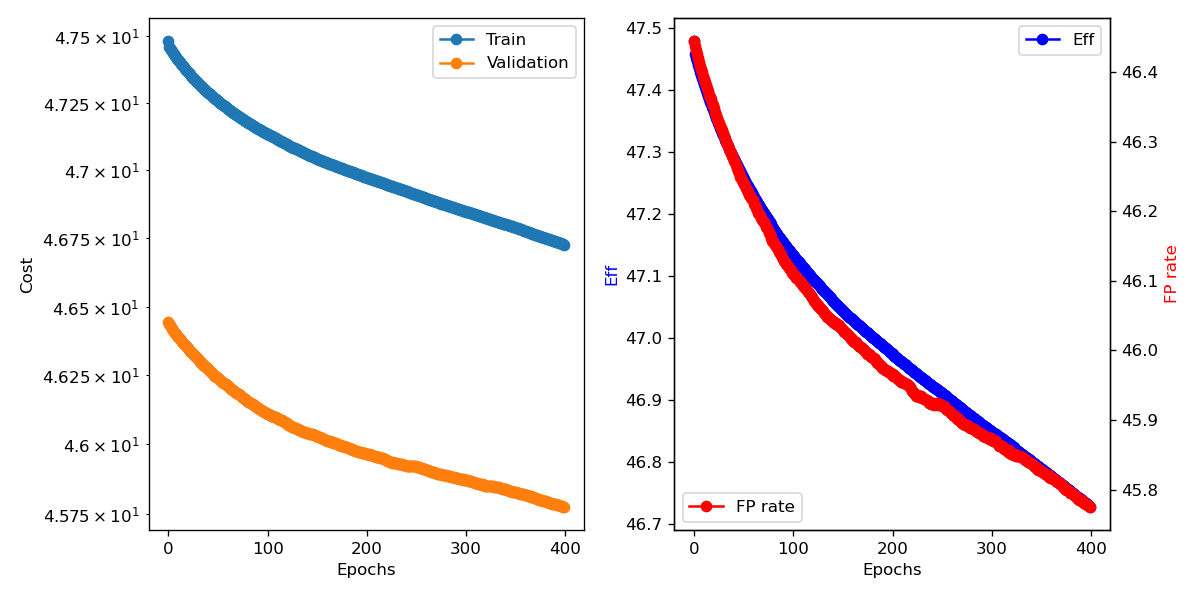

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))